# VAR model for Dissertation M2 "Nowcasting Macroeconomic growth"

# Install Required Libraries:

In [1]:
#pip install statsmodels
#pip install pandas
#pip install numpy
#pip install matplotlib

# Import Libraries:

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
pd.reset_option('all')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [3]:
#make a function that print all the accuracy values for the data
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

# Load data

In [4]:
#Read sentiments data index
sentiments_data = pd.read_csv("C:\\Users\cata9\OneDrive\Documentos\Memoire_Nowcasting_Macroeconomic_Growth\Sentiments_data.csv", sep=";")

In [5]:
#Ensure date strings are read as dates
sentiments_data["Date Time"] = sentiments_data["Date Time"].apply(lambda x: pd.to_datetime(x,dayfirst=True))

#Show the sentiment data
sentiments_data = sentiments_data.set_index("Date Time")
sentiments_data.head()

,Economic Sentiment Indicator
Date Time,
1999-11-30,0.58
1999-12-01,0.07
1999-12-02,0.29
1999-12-03,0.14
1999-12-05,0.26


In [6]:
sentiments_data.index

DatetimeIndex(['1999-11-30', '1999-12-01', '1999-12-02', '1999-12-03',
               '1999-12-05', '1999-12-06', '1999-12-07', '1999-12-08',
               '1999-12-09', '1999-12-10',
               ...
               '2023-05-21', '2023-05-22', '2023-05-23', '2023-05-24',
               '2023-05-25', '2023-05-29', '2023-05-30', '2023-05-31',
               '2023-06-01', '2023-06-02'],
              dtype='datetime64[ns]', name='Date Time', length=7355, freq=None)

In [7]:
sentiments_data.index.quarter

Int64Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
            ...
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
           dtype='int64', name='Date Time', length=7355)

In [8]:
ts = pd.Timestamp(2022, 1, 1)
ts + pd.offsets.QuarterEnd()+pd.tseries.offsets.Day()

Timestamp('2022-04-01 00:00:00')

In [9]:
#Convert daily sentiment data into quarterly data
sentiments_data_Q = sentiments_data.groupby(pd.PeriodIndex(sentiments_data.index, freq="Q")).mean() 

#Only keep complete quarters (i.e. get rid of Q2 of 2023)
sentiments_data_Q = sentiments_data_Q.loc[sentiments_data_Q.index[:-1]]

#Change index type to match GDP data
sentiments_data_Q.index = sentiments_data_Q.index.to_timestamp()
sentiments_data_Q.index = sentiments_data_Q.index+pd.offsets.QuarterEnd()+pd.tseries.offsets.Day()

#Plot the head of quarterly sentiment index
sentiments_data_Q

,Economic Sentiment Indicator
Date Time,
2000-01-01,0.367143
2000-04-01,0.313333
2000-07-01,0.501282
2000-10-01,0.330641
2001-01-01,0.276835
...,...
2022-04-01,-0.366494
2022-07-01,-0.307821
2022-10-01,-0.274304


In [10]:
sentiments_data_Q.index

DatetimeIndex(['2000-01-01', '2000-04-01', '2000-07-01', '2000-10-01',
               '2001-01-01', '2001-04-01', '2001-07-01', '2001-10-01',
               '2002-01-01', '2002-04-01', '2002-07-01', '2002-10-01',
               '2003-01-01', '2003-04-01', '2003-07-01', '2003-10-01',
               '2004-01-01', '2004-04-01', '2004-07-01', '2004-10-01',
               '2005-01-01', '2005-04-01', '2005-07-01', '2005-10-01',
               '2006-01-01', '2006-04-01', '2006-07-01', '2006-10-01',
               '2007-01-01', '2007-04-01', '2007-07-01', '2007-10-01',
               '2008-01-01', '2008-04-01', '2008-07-01', '2008-10-01',
               '2009-01-01', '2009-04-01', '2009-07-01', '2009-10-01',
               '2010-01-01', '2010-04-01', '2010-07-01', '2010-10-01',
               '2011-01-01', '2011-04-01', '2011-07-01', '2011-10-01',
               '2012-01-01', '2012-04-01', '2012-07-01', '2012-10-01',
               '2013-01-01', '2013-04-01', '2013-07-01', '2013-10-01',
      

In [11]:
sentiments_data_Q.index+pd.offsets.QuarterEnd()+pd.tseries.offsets.Day()

DatetimeIndex(['2000-04-01', '2000-07-01', '2000-10-01', '2001-01-01',
               '2001-04-01', '2001-07-01', '2001-10-01', '2002-01-01',
               '2002-04-01', '2002-07-01', '2002-10-01', '2003-01-01',
               '2003-04-01', '2003-07-01', '2003-10-01', '2004-01-01',
               '2004-04-01', '2004-07-01', '2004-10-01', '2005-01-01',
               '2005-04-01', '2005-07-01', '2005-10-01', '2006-01-01',
               '2006-04-01', '2006-07-01', '2006-10-01', '2007-01-01',
               '2007-04-01', '2007-07-01', '2007-10-01', '2008-01-01',
               '2008-04-01', '2008-07-01', '2008-10-01', '2009-01-01',
               '2009-04-01', '2009-07-01', '2009-10-01', '2010-01-01',
               '2010-04-01', '2010-07-01', '2010-10-01', '2011-01-01',
               '2011-04-01', '2011-07-01', '2011-10-01', '2012-01-01',
               '2012-04-01', '2012-07-01', '2012-10-01', '2013-01-01',
               '2013-04-01', '2013-07-01', '2013-10-01', '2014-01-01',
      

In [12]:
sentiments_data_Q = sentiments_data_Q.loc[(sentiments_data_Q.index < "2020-01-01") & (sentiments_data_Q.index > "2000-01-01")]
sentiments_data_Q

,Economic Sentiment Indicator
Date Time,
2000-04-01,0.313333
2000-07-01,0.501282
2000-10-01,0.330641
2001-01-01,0.276835
2001-04-01,0.134545
...,...
2018-10-01,-0.015063
2019-01-01,0.027595
2019-04-01,-0.074156


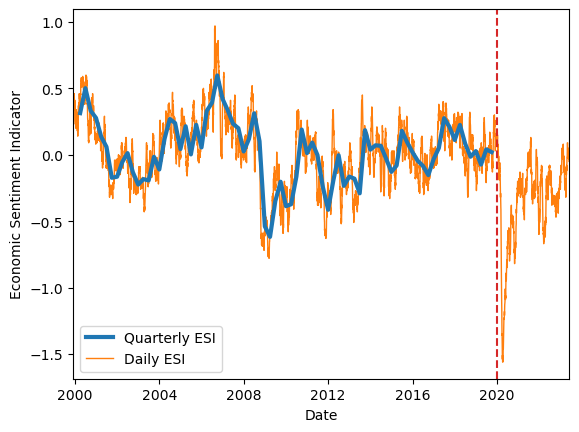

In [13]:
#Plot  sentiment data
fig, ax = plt.subplots()

ax.plot(sentiments_data_Q.index,sentiments_data_Q["Economic Sentiment Indicator"],linewidth=3,label="Quarterly ESI",zorder=1)
ax.plot(sentiments_data.index,sentiments_data["Economic Sentiment Indicator"],linewidth=1,label="Daily ESI",zorder=0)

ylim=plt.ylim()

ax.plot(pd.to_datetime(["2020-01-01","2020-01-01"]),ylim,ls="--",color="C3")

plt.xlabel("Date")
plt.ylabel("Economic Sentiment Indicator")
plt.ylim(ylim)
plt.xlim([min(sentiments_data.index),max(sentiments_data.index)])
plt.legend()
#sentiments_data_Q.plot(ax=ax,linewidth=3,zorder=1,label="Quarterly ESI")
#sentiments_data.plot(ax=ax,zorder=0,label="Daily ESI")

In [14]:
#Load GDP data
gdp_data = pd.read_csv("C:\\Users\cata9\OneDrive\Documentos\Memoire_Nowcasting_Macroeconomic_Growth\Belgium_GDP_CSV.csv",sep=";")

#Ensure date strings are read as dates
gdp_data["Date Time"] = gdp_data["Date Time"].apply(lambda x: pd.to_datetime(x,dayfirst=True))

gdp_data = gdp_data.set_index("Date Time")
gdp_data

,Economic Growth
Date Time,
1995-04-01,0.42
1995-07-01,0.60
1995-10-01,0.21
1996-01-01,-0.20
1996-04-01,0.70
...,...
2022-01-01,0.62
2022-04-01,0.53
2022-07-01,0.31


<AxesSubplot:xlabel='Date Time'>

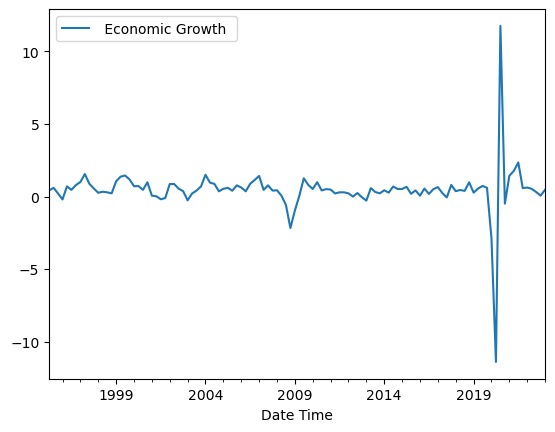

In [15]:
gdp_data.plot()

In [16]:
gdp_data.index

DatetimeIndex(['1995-04-01', '1995-07-01', '1995-10-01', '1996-01-01',
               '1996-04-01', '1996-07-01', '1996-10-01', '1997-01-01',
               '1997-04-01', '1997-07-01',
               ...
               '2020-10-01', '2021-01-01', '2021-04-01', '2021-07-01',
               '2021-10-01', '2022-01-01', '2022-04-01', '2022-07-01',
               '2022-10-01', '2023-01-01'],
              dtype='datetime64[ns]', name='Date Time', length=112, freq=None)

In [17]:
gdp_data = gdp_data.loc[(gdp_data.index < "2020-01-01") & (gdp_data.index >= "2000-01-01")]
gdp_data

,Economic Growth
Date Time,
2000-01-01,0.71
2000-04-01,0.72
2000-07-01,0.46
2000-10-01,0.98
2001-01-01,0.06
...,...
2018-10-01,0.98
2019-01-01,0.27
2019-04-01,0.55


<AxesSubplot:xlabel='Date Time'>

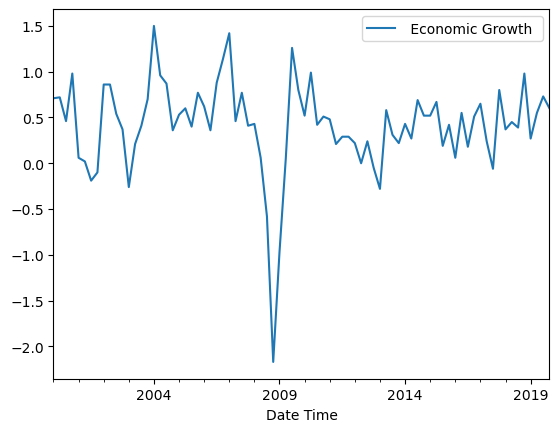

In [18]:
#Plot gdp data
gdp_data.plot()

# Combine the data

In [19]:
#Merge the two dataframes based on the common date column to ensure alignment of the data:
df = pd.DataFrame()

In [20]:
#Fill the Data Frame with the data
df["Sentiments"] = sentiments_data_Q
df["GDP"] = gdp_data

df

,Sentiments,GDP
Date Time,,
2000-04-01,0.313333,0.72
2000-07-01,0.501282,0.46
2000-10-01,0.330641,0.98
2001-01-01,0.276835,0.06
2001-04-01,0.134545,0.02
...,...,...
2018-10-01,-0.015063,0.98
2019-01-01,0.027595,0.27
2019-04-01,-0.074156,0.55


<AxesSubplot:xlabel='Date Time'>

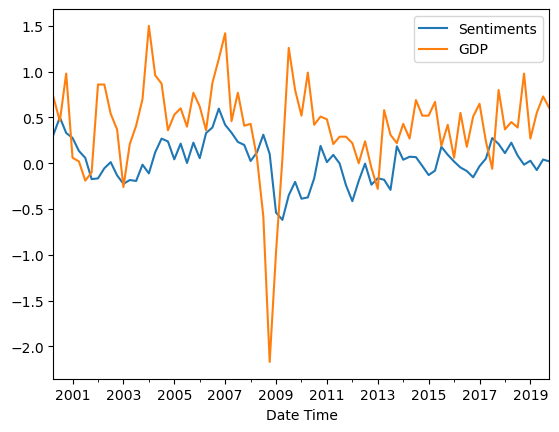

In [21]:
#Plot together quarterly Sentiments index and quarterly GDP data
df.plot()

In [22]:
#Split the dataset into training and test sets

training_size = 55
training_set = df.iloc[:training_size]
test_set = df.iloc[training_size:]

# Tests

# The Granger causality test
is a statistical hypothesis test for determining whether one time series is useful in forecasting another. Rather than testing whether X causes Y, the Granger causality tests whether X forecasts Y. We can use this test because we have a linear and stationary relation between both time series. Before we do the granger causality test, we calculate the number of lags using  Akaike criterion information.

In [23]:
import statsmodels.api as sm

# Define the range of lag orders to consider
max_lag = 23

# Initialize variables
best_aic = float("inf")
best_lag_order = None

# Iterate over lag orders and calculate AIC
for lag_order in range(1, max_lag + 1):
    # Fit the model
    model = VAR(df)
    results = model.fit()
    
    # Calculate AIC
    aic = results.aic
    
    # Check if current AIC is the best so far
    if aic < best_aic:
        best_aic = aic
        best_lag_order = lag_order

# Output the optimal lag order
print("Optimal Lag Order:", best_lag_order)
print("Best AIC: ", best_aic)

Optimal Lag Order: 1
Best AIC:  -5.5080028591623815


C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

In [24]:
df

,Sentiments,GDP
Date Time,,
2000-04-01,0.313333,0.72
2000-07-01,0.501282,0.46
2000-10-01,0.330641,0.98
2001-01-01,0.276835,0.06
2001-04-01,0.134545,0.02
...,...,...
2018-10-01,-0.015063,0.98
2019-01-01,0.027595,0.27
2019-04-01,-0.074156,0.55


In [25]:
from statsmodels.tsa.stattools import grangercausalitytests

#perform Granger-Causality test
max_lag_causality = 3 #We select 3 lags, where lag 1 is within it
grangercausalitytests(df, maxlag=max_lag_causality)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=21.4970 , p=0.0000  , df_denom=75, df_num=1
ssr based chi2 test:   chi2=22.3569 , p=0.0000  , df=1
likelihood ratio test: chi2=19.6579 , p=0.0000  , df=1
parameter F test:         F=21.4970 , p=0.0000  , df_denom=75, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=11.0281 , p=0.0001  , df_denom=72, df_num=2
ssr based chi2 test:   chi2=23.5878 , p=0.0000  , df=2
likelihood ratio test: chi2=20.5764 , p=0.0000  , df=2
parameter F test:         F=11.0281 , p=0.0001  , df_denom=72, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.5033  , p=0.0002  , df_denom=69, df_num=3
ssr based chi2 test:   chi2=24.7934 , p=0.0000  , df=3
likelihood ratio test: chi2=21.4578 , p=0.0001  , df=3
parameter F test:         F=7.5033  , p=0.0002  , df_denom=69, df_num=3


{1: ({'ssr_ftest': (21.497031923706178, 1.4678474278260936e-05, 75.0, 1),
   'ssr_chi2test': (22.35691320065442, 2.263966092346746e-06, 1),
   'lrtest': (19.657882691329178, 9.26204329187756e-06, 1),
   'params_ftest': (21.497031923706192, 1.4678474278260854e-05, 75.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (11.028083402394245, 6.63785799678537e-05, 72.0, 2),
   'ssr_chi2test': (23.587845055121026, 7.550305533110336e-06, 2),
   'lrtest': (20.576402308793718, 3.4032277195496566e-05, 2),
   'params_ftest': (11.028083402394271, 6.637857996785231e-05, 72.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (7.503280304843127, 0.0002036226694885633, 69.0, 3),
   'ssr_chi2test': (24.793447963829465, 1.7054607454435528e-05, 3),
   'lrtest': (21.45784097884109, 8.456791893229597e-05, 3),
   'params_ftest': (7.503280304843123, 0.0002036226694885633, 69.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 

The F test statistic with a maximum lag of 1 (selected by Akaike criterion) is 21.497 and the corresponding p-value is 0.00.

Since the p-value is less than .05, we can reject the null hypothesis of the test and conclude that the knowing Sentiment is useful for predicting/forecasting the GDP.

# The cointegration test 
is use to know when two or more time series are cointegrated, if they do, it means they have a long run, statistically significant relationship.

This is the basic premise on which Vector Autoregression(VAR) models is based on. So, we implement the cointegration test before starting to build the VAR model.

In [26]:
#Import coint_johansen
from statsmodels.tsa.vector_ar.vecm import coint_johansen

#Make the function for the cointeration test
def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,0,1)   #0=the order of null hypothesis, implies that it is a constant term, there is no time trend in the polynomial. 1=number of lagged difference terms used when computing the estimator.
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
Sentiments ::  49.16     > 15.4943   =>   True
GDP    ::  15.51     > 3.8415    =>   True


# Check for stationarity
The assumption of stationarity is that the mean and variance of the two series are approximately constant with time. We use the common Augmented Dickey Fuller test to check this assumption.

The null hypothesis for the ADF test is that the series in question is not stationary. So a rejection favours the alternative hypothesis of stationarity.

In [27]:
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    """Function to apply Augmented Dickey Fuller test"""
    dftest = adfuller(timeseries, autolag='AIC')
    result = pd.Series(dftest[0:4], index=['Test Statistic','P-value','Lags Used','No of Observations'])
    for key,value in dftest[4].items():
        result['Critical Value (%s)'%key] = value
    return result

In [28]:
training_set.apply(adf_test, axis = 0)

,Sentiments,GDP
Test Statistic,-2.929873,-3.714559
P-value,0.041983,0.003913
Lags Used,0.000000,0.000000
No of Observations,54.000000,54.000000
Critical Value (1%),-3.557709,-3.557709
Critical Value (5%),-2.916770,-2.916770
Critical Value (10%),-2.596222,-2.596222


From the above table, we can see that both the p-values of both series are less than 0.05, so we can reject the null hypothesis and say the two series are stationary.

# Train the Autoregressive model AR(p)

In [29]:
modAR = AutoReg(training_set["GDP"] ,1 )
resAR = modAR.fit()
print(resAR.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GDP   No. Observations:                   55
Model:                     AutoReg(1)   Log Likelihood                 -35.871
Method:               Conditional MLE   S.D. of innovations              0.470
Date:                Wed, 30 Aug 2023   AIC                             77.742
Time:                        22:15:15   BIC                             83.709
Sample:                    07-01-2000   HQIC                            80.043
                         - 10-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1553      0.077      2.008      0.045       0.004       0.307
GDP.L1         0.5828      0.110      5.288      0.000       0.367       0.799
                                    Roots           

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [30]:
#define the prediction data frame
predictionsAR = pd.DataFrame(index=test_set.index,columns=["GDP","lower","upper"])
lag_order_AR=1
#Make a loop to forecast taking every point in the past
for i in range(len(test_set)):
    modAR = AutoReg(df.iloc[:-len(test_set)+i]["GDP"] ,1 )
    resAR = modAR.fit()
    #forecastAR = resAR.forecast(1)[0]
    #predictionsAR.iloc[i]["Sentiments"] = forecast[0]
    #predictionsAR.iloc[i]["GDP"] = forecastAR
    
    pred = resAR.get_prediction(start=test_set.index[i],end=test_set.index[i])
    forecastAR = pred.predicted_mean[0]
    #predictionsAR.iloc[i]["Sentiments"] = forecast[0]
    predictionsAR.iloc[i]["GDP"] = forecastAR
    predictionsAR.iloc[i]["lower"] = pred.predicted_mean[0]-2*np.sqrt(pred.var_pred_mean[0])
    predictionsAR.iloc[i]["upper"] = pred.predicted_mean[0]+2*np.sqrt(pred.var_pred_mean[0])

predictionsAR

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

,GDP,lower,upper
Date Time,,,
2014-01-01,0.283517,-0.656825,1.223859
2014-04-01,0.408517,-0.524057,1.341092
2014-07-01,0.31305,-0.611889,1.237988
2014-10-01,0.563001,-0.359111,1.485113
2015-01-01,0.463799,-0.450397,1.377995
2015-04-01,0.464798,-0.441734,1.371329
2015-07-01,0.555337,-0.345142,1.455815
2015-10-01,0.272217,-0.625638,1.170072
2016-01-01,0.406685,-0.484676,1.298046


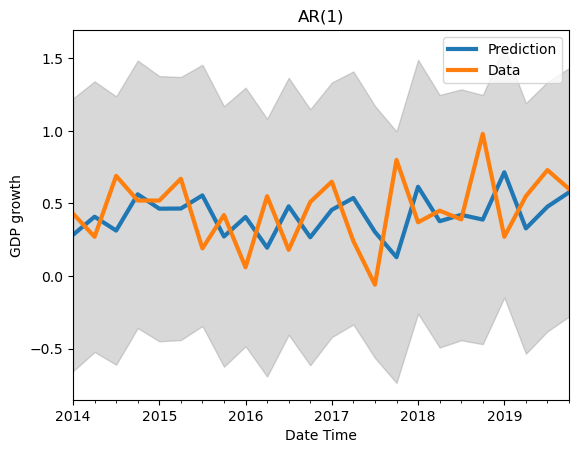

In [31]:
fig, ax = plt.subplots()
predictionsAR["GDP"].plot(ax=ax,label="Prediction",lw=3)
test_set["GDP"].plot(ax=ax,label="Data",lw=3)
ax.fill_between(predictionsAR.index,predictionsAR["lower"].apply(lambda x: float(x)) ,predictionsAR["upper"].apply(lambda x: float(x)),alpha=0.3,color="grey")
plt.legend()
plt.title("AR(1)")
plt.ylabel("GDP growth")
plt.savefig("AR(1)plot.png")
plt.show()

In [32]:
print('Forecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(predictionsAR['GDP'].values.astype(float), test_set['GDP'].values.astype(float))
    
#compare_results_df = pd.DataFrame(accuracy_prod.values(),index=accuracy_prod.keys(),columns=["AR(1)"])
compare_results_df = pd.DataFrame(accuracy_prod.values(),index=accuracy_prod.keys(),columns=["AR(1)"])
compare_results_df

Forecast Accuracy of: GDP


,AR(1)
mape,1.046693
me,-0.040880
mae,0.255580
mpe,0.086261
rmse,0.303869
corr,-0.237768
minmax,0.452661


# The Autorregrassive model with exogenous variable ARX(n,m)

In [33]:
modARX = AutoReg(training_set["GDP"] ,1, exog=training_set["Sentiments"] )
resARX = modARX.fit()
print(resARX.summary())

                            AutoReg Model Results                             
Dep. Variable:                    GDP   No. Observations:                   55
Model:                   AutoReg-X(1)   Log Likelihood                 -35.447
Method:               Conditional MLE   S.D. of innovations              0.466
Date:                Wed, 30 Aug 2023   AIC                             78.894
Time:                        22:15:16   BIC                             86.850
Sample:                    07-01-2000   HQIC                            81.963
                         - 10-01-2013                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1348      0.080      1.687      0.092      -0.022       0.291
GDP.L1         0.6397      0.126      5.097      0.000       0.394       0.886
Sentiments    -0.2562      0.277     -0.924      0.3

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [34]:
#define the prediction data frame
predictionsARX = pd.DataFrame(index=test_set.index,columns=["GDP","lower","upper"])

#Make a loop to forecast taking every point in the past
for i in range(len(test_set)):
    #modARX = AutoReg(training_set["GDP"] ,1, exog=training_set["Sentiments"] )
    modARX = AutoReg(df.iloc[:-len(test_set)+i]["GDP"] ,1, exog=df.iloc[:-len(test_set)+i]["Sentiments"]  )
    resARX = modARX.fit()
    #forecastARX = resARX.forecast(1,test_set["Sentiments"][i])[0]
    #print(resARX.forecast_interval(1,test_set["Sentiments"][i])[0])
    pred = resARX.get_prediction(start=test_set.index[i],end=test_set.index[i],exog_oos=test_set["Sentiments"][i])
    forecastARX = pred.predicted_mean[0]
    #predictionsAR.iloc[i]["Sentiments"] = forecast[0]
    predictionsARX.iloc[i]["GDP"] = forecastARX
    predictionsARX.iloc[i]["lower"] = pred.predicted_mean[0]-2*np.sqrt(pred.var_pred_mean[0])
    predictionsARX.iloc[i]["upper"] = pred.predicted_mean[0]+2*np.sqrt(pred.var_pred_mean[0])

predictionsARX

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

,GDP,lower,upper
Date Time,,,
2014-01-01,0.265738,-0.667251,1.198727
2014-04-01,0.394786,-0.53072,1.320293
2014-07-01,0.291456,-0.626344,1.209257
2014-10-01,0.588826,-0.326868,1.50452
2015-01-01,0.50369,-0.40425,1.411631
2015-04-01,0.492555,-0.407668,1.392778
2015-07-01,0.526774,-0.367065,1.420613
2015-10-01,0.237891,-0.652673,1.128456
2016-01-01,0.405632,-0.478902,1.290166


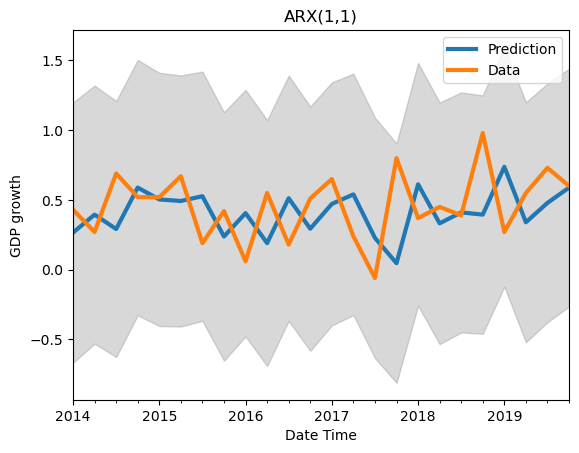

In [35]:
#fig = resARX.plot_predict(start=training_set.index[-1],end=test_set.index[-1],exog_oos=test_set["Sentiments"],alpha=0.32)
#fig.axes[0].plot(test_set.index,test_set["GDP"],label="GDP")

#plt.legend()

fig, ax = plt.subplots()
predictionsARX["GDP"].plot(ax=ax,label="Prediction",lw=3)
test_set["GDP"].plot(ax=ax,label="Data",lw=3)
ax.fill_between(predictionsARX.index,predictionsARX["lower"].apply(lambda x: float(x)) ,predictionsARX["upper"].apply(lambda x: float(x)),alpha=0.3,color="grey")
plt.legend()
plt.title("ARX(1,1)")
plt.ylabel("GDP growth")
plt.show()

The grey area shows the 95% corresponding to 2 sigma, confidence interval. Confidence interval is constructed assuming normally distributed shocks.

In [36]:
#predictionsARexog = pd.DataFrame()
#predictionsARexog['GDP'] = res.predict(start=training_set.index[-1],end=test_set.index[-1],exog_oos=test_set["Sentiments"])

In [37]:
print('Forecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(predictionsARX['GDP'].values.astype(float) , test_set['GDP'].values.astype(float))
    
compare_results_df["ARX"] = accuracy_prod.values()
compare_results_df

Forecast Accuracy of: GDP


,AR(1),ARX
mape,1.046693,1.001969
me,-0.040880,-0.045628
mae,0.255580,0.256174
mpe,0.086261,0.136603
rmse,0.303869,0.309823
corr,-0.237768,-0.179728
minmax,0.452661,0.460765


# The Vector Autoregressive model: VAR

In [38]:
#Select the optimal lag for training set
model = VAR(training_set)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -5.053031459148896
BIC :  -4.832033231752865
FPE :  0.006391397003121025
HQIC:  -4.967801109469316 

Lag Order = 2
AIC :  -4.9455867421078175
BIC :  -4.5738335508715675
FPE :  0.0071227511309240096
HQIC:  -4.802628394236909 

Lag Order = 3
AIC :  -4.902505278905309
BIC :  -4.377170431594925
FPE :  0.007452416706227961
HQIC:  -4.701104297080795 

Lag Order = 4
AIC :  -4.904857512220152
BIC :  -4.223036700670391
FPE :  0.007466044207853987
HQIC:  -4.6443136141454175 

Lag Order = 5
AIC :  -4.907918428865415
BIC :  -4.06662830647703
FPE :  0.007496687724090268
HQIC:  -4.587550351923582 

Lag Order = 6
AIC :  -4.821559273770745
BIC :  -3.8177362584467396
FPE :  0.008266427301281245
HQIC:  -4.440710221950592 

Lag Order = 7
AIC :  -4.638372822962562
BIC :  -3.4688721911451297
FPE :  0.010101023808313679
HQIC:  -4.196416825921968 

Lag Order = 8
AIC :  -4.6500708792224765
BIC :  -3.3116662311769023
FPE :  0.010239443705658612
HQIC:  -4.146420219102276 

Lag Order = 9
AIC

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


Again for the training set, as we saw already for the df above, the AIC drops to lowest at lag 1, then increases at lag 2 and so on.

# Train the VAR model 
Train the model at the selected order before

In [39]:
result = model.fit(1)
result.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 30, Aug, 2023
Time:                     22:15:18
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.83203
Nobs:                     54.0000    HQIC:                  -4.96780
Log likelihood:          -10.8135    FPE:                 0.00639140
AIC:                     -5.05303    Det(Omega_mle):      0.00573632
--------------------------------------------------------------------
Results for equation Sentiments
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                -0.061692         0.026344           -2.342           0.019
L1.Sentiments         0.651072         0.083789            7.770           0.000
L1.GDP                0.159197         0.038253        

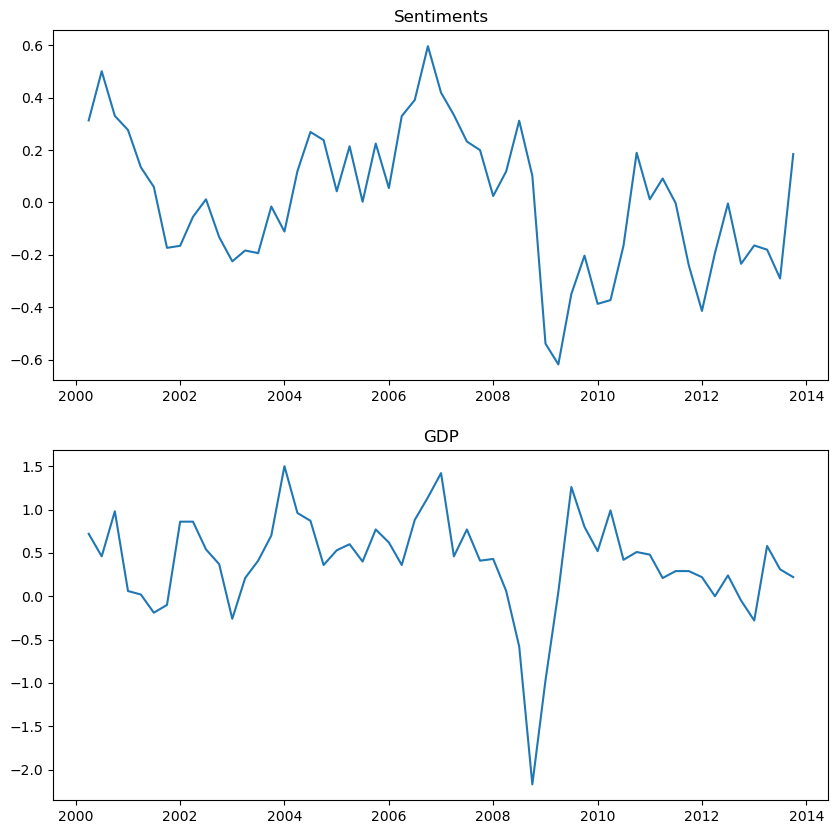

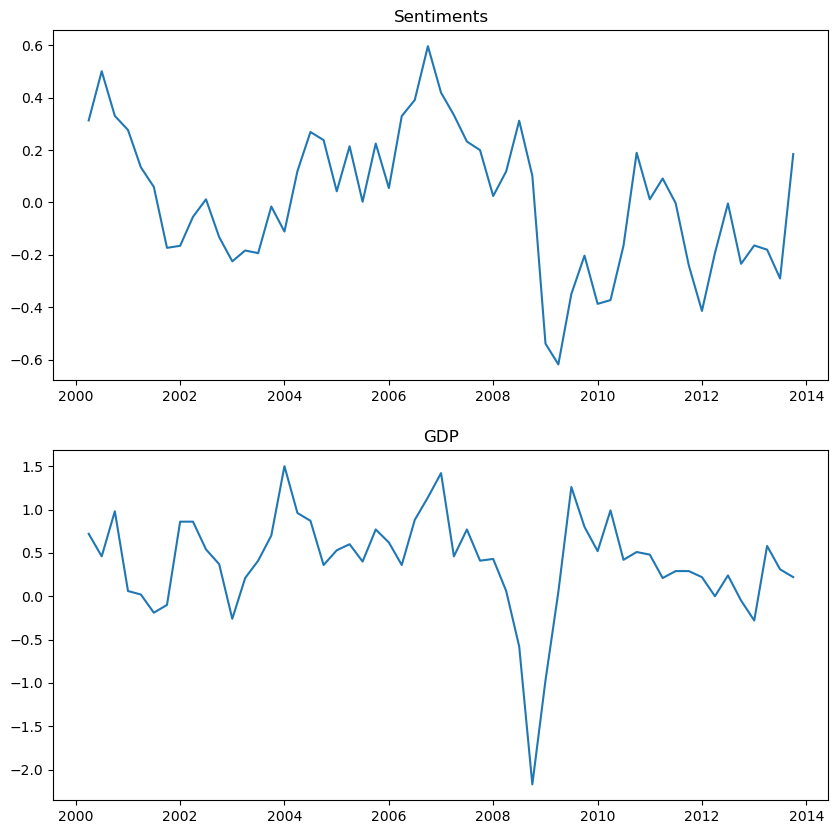

In [40]:
result.plot()

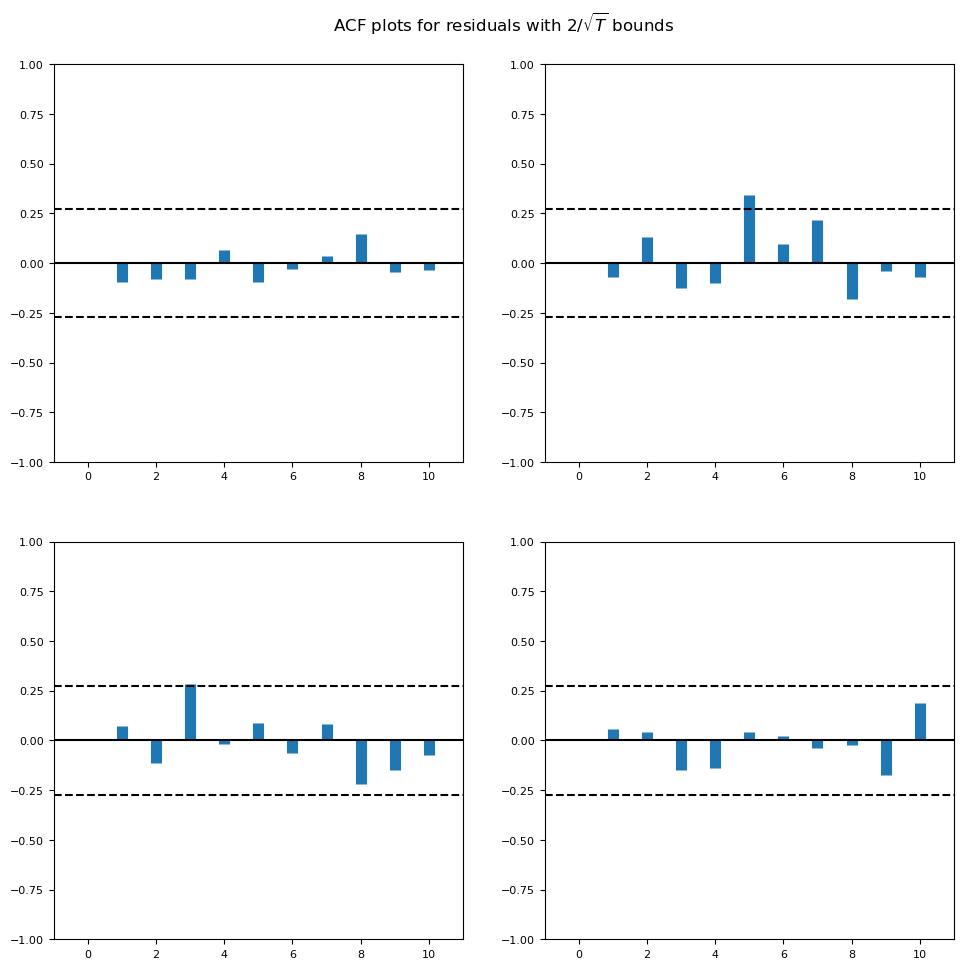

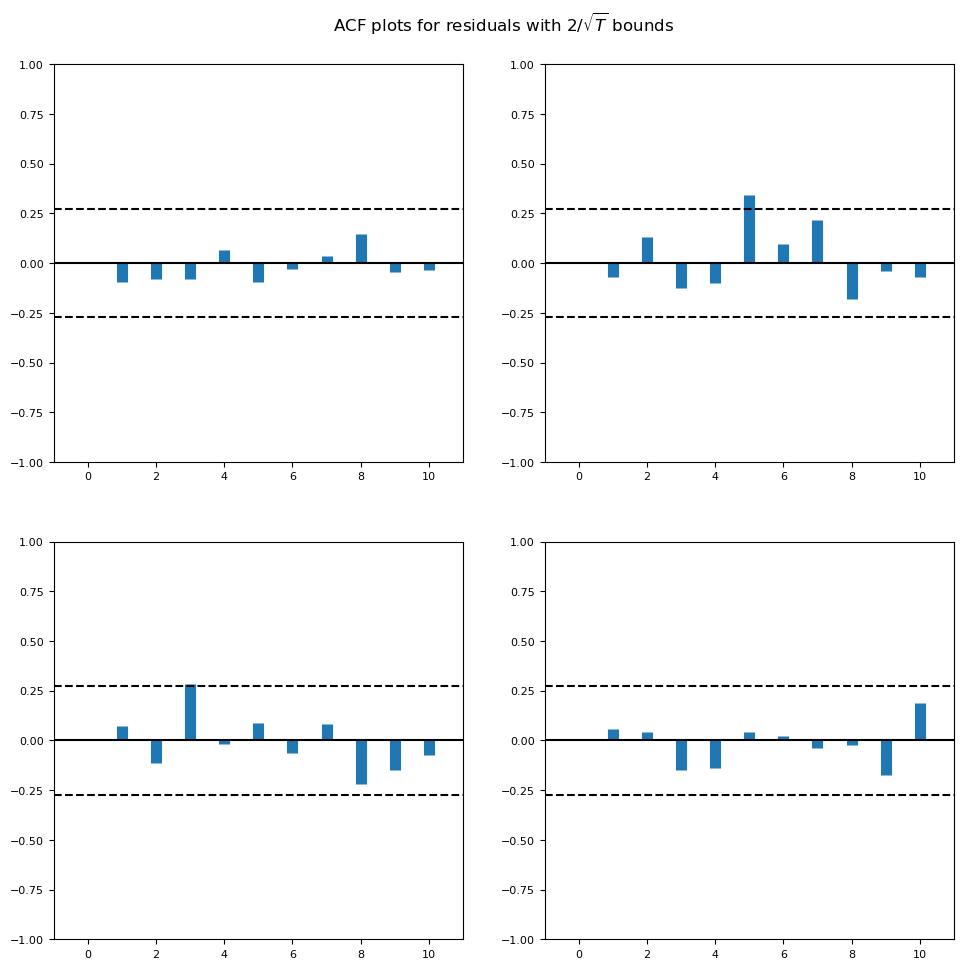

In [41]:
result.plot_acorr()

In [42]:
lag_order = results.k_ar
lag_order

1

# Check for Serial Correlation of Residuals Errors using Durbin Watson Statistic
If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model.The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [43]:
#Import Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(result.resid)

#print the value for each variable
for column, val in zip(training_set.columns, out):
    print(column, ':', round(val, 2))

Sentiments : 2.03
GDP : 1.88


# Forecast VAR model

In [44]:
#define the prediction data frame
predictions = pd.DataFrame(index=test_set.index,columns=test_set.columns)

In [45]:
#Make a loop to forecast taking every point in the past
for i in range(len(test_set)):
    forecast_input = df.values[-len(test_set)-lag_order+i:-len(test_set)-lag_order+i+1]
    #print(forecast_input)
    forecast = results.forecast(forecast_input, 1)[0]
    predictions.iloc[i]["Sentiments"] = forecast[0]
    predictions.iloc[i]["GDP"] = forecast[1]

predictions

,Sentiments,GDP
Date Time,,
2014-01-01,0.094762,0.262853
2014-04-01,0.031317,0.414412
2014-07-01,0.028469,0.31863
2014-10-01,0.089481,0.549461
2015-01-01,0.000859,0.480622
2015-04-01,-0.063654,0.50544
2015-07-01,-0.009736,0.57552
2015-10-01,0.086919,0.247706
2016-01-01,0.065514,0.395201


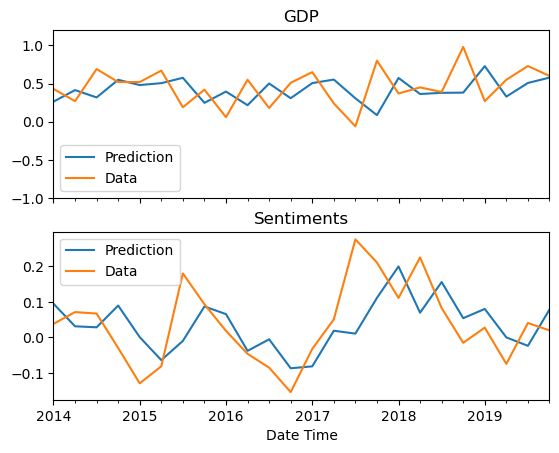

In [46]:
#Plot the actual data vs the prediction
fig, axs = plt.subplots(2,sharex=True)

axs[0].set_title("GDP")
axs[0].set_ylim([-1,1.2])
predictions["GDP"].plot(ax=axs[0],label="Prediction")
test_set["GDP"].plot(ax=axs[0],label="Data")

axs[0].legend()

axs[1].set_title("Sentiments")
predictions["Sentiments"].plot(ax=axs[1],label="Prediction")
test_set["Sentiments"].plot(ax=axs[1],label="Data")

axs[1].legend()

In [47]:
#Show prediction plus limits of the confidence interval (upper and lower)
predictions2 = pd.DataFrame(index=test_set.index,columns=["GDP","lower","upper"])

for i in range(len(test_set)):
    forecast_input = df.values[-len(test_set)-lag_order+i:-len(test_set)-lag_order+i+1]
    pred, lower, upper = results.forecast_interval(forecast_input, 1, alpha=0.05)
    predictions2.iloc[i]["lower"] = lower[0][1]
    predictions2.iloc[i]["upper"] = upper[0][1]
    predictions2.iloc[i]["GDP"] = pred[0][1]

predictions2

,GDP,lower,upper
Date Time,,,
2014-01-01,0.262853,-0.579712,1.105419
2014-04-01,0.414412,-0.428154,1.256977
2014-07-01,0.31863,-0.523935,1.161196
2014-10-01,0.549461,-0.293104,1.392027
2015-01-01,0.480622,-0.361943,1.323188
2015-04-01,0.50544,-0.337125,1.348006
2015-07-01,0.57552,-0.267045,1.418086
2015-10-01,0.247706,-0.594859,1.090272
2016-01-01,0.395201,-0.447364,1.237767


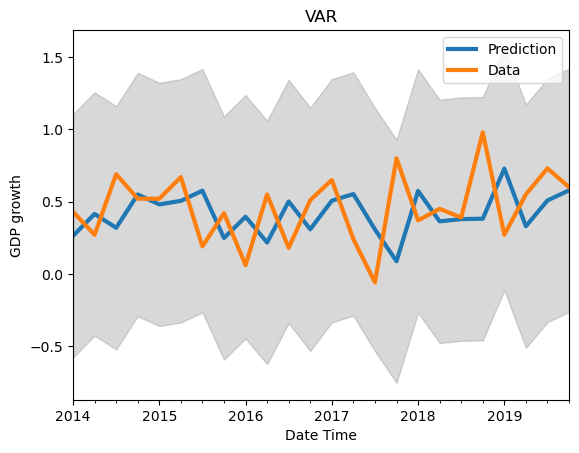

In [48]:
#plot the actual plus the prediction with the confidence interval
fig, ax = plt.subplots()

ax.set_title("VAR")
predictions2["GDP"].plot(ax=ax,label="Prediction",lw=3)
test_set["GDP"].plot(ax=ax,label="Data",lw=3)
ax.fill_between(predictions2.index,predictions2["lower"].apply(lambda x: float(x)) ,predictions2["upper"].apply(lambda x: float(x)),alpha=0.3,color="grey")
plt.ylabel("GDP growth")

ax.legend()
plt.show()

# Evaluate the Forecasts with VAR

In [49]:
print('Forecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(predictions['GDP'].values.astype(float), test_set['GDP'].values.astype(float))

compare_results_df["VAR"] = accuracy_prod.values()
    
compare_results_df

Forecast Accuracy of: GDP


,AR(1),ARX,VAR
mape,1.046693,1.001969,1.042072
me,-0.040880,-0.045628,-0.037882
mae,0.255580,0.256174,0.251042
mpe,0.086261,0.136603,0.086488
rmse,0.303869,0.309823,0.305457
corr,-0.237768,-0.179728,-0.218724
minmax,0.452661,0.460765,0.443833


# The forecast with Dynamic Factor Model

In [89]:
#Import the necessary libraries
import statsmodels.tsa.api as sm
from sklearn.decomposition import FactorAnalysis
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [98]:
endog = training_set

With factors=2, there will be two independent factors that will each evolve according to separate AR(1) processes.

In [121]:
modDFM2 = sm.DynamicFactorMQ(endog, factor=2)
print(modDFM2.summary())

                         Model Specification: Dynamic Factor Model                         
Model:                Dynamic Factor Model   # of observed variables:                     2
                   + 1 factors in 1 blocks   # of factors:                                1
                     + AR(1) idiosyncratic   Idiosyncratic disturbances:              AR(1)
Sample:                2000-04-01 00:00:00   Standardize variables:                    True
                     - 2013-10-01 00:00:00                                                 
Observed variables / factor loadings
Dep. variable          0
------------------------
   Sentiments          X
          GDP          X
    Factor blocks:   
     block      order
---------------------
         0          1


C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


To fit the model, use the fit method. This method uses the EM algorithm by default.

In [120]:
resDFM2 = modDFM2.fit()
print(res.summary())

                               Dynamic Factor Results                              
Dep. Variable:       ['Sentiments', 'GDP']   No. Observations:                   55
Model:                Dynamic Factor Model   Log Likelihood                -120.567
                   + 1 factors in 1 blocks   AIC                            257.134
                     + AR(1) idiosyncratic   BIC                            273.193
Date:                     Thu, 31 Aug 2023   HQIC                           263.344
Time:                             19:25:34   EM Iterations                      257
Sample:                         04-01-2000                                         
                              - 10-01-2013                                         
Covariance Type:              Not computed                                         
                    Observation equation:                     
Factor loadings:          0    idiosyncratic: AR(1)       var.
----------------------------------

In [144]:
modDFM2 = sm.DynamicFactorMQ(endog)
resDFM2 = mod.fit()

#define the prediction data frame
forecastingDFM2 = pd.DataFrame(index=test_set.index,columns=test_set.columns)
forecastingDFM2 = resDFM2.forecast(steps=24)
print(forecastingDFM2)

2019-11-01    0.069802
2019-12-01    0.060226
2020-01-01    0.052413
2020-02-01    0.046037
2020-03-01    0.040834
2020-04-01    0.036588
2020-05-01    0.033124
2020-06-01    0.030297
2020-07-01    0.027991
2020-08-01    0.026109
2020-09-01    0.024573
2020-10-01    0.023319
2020-11-01    0.022297
2020-12-01    0.021462
2021-01-01    0.020781
2021-02-01    0.020226
2021-03-01    0.019772
2021-04-01    0.019402
2021-05-01    0.019100
2021-06-01    0.018854
2021-07-01    0.018653
2021-08-01    0.018489
2021-09-01    0.018355
2021-10-01    0.018246
Freq: MS, Name: predicted_mean, dtype: float64


C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [145]:
num_oos=len(test_set)
h=1
dfm2_forecast = pd.DataFrame()

# Refit w/o test set
modeldfm2 = sm.DynamicFactorMQ(endog=training_set.iloc[:-num_oos], factors=1, factor_orders=1,
                           idiosyncratic_ar1=True)
resultsdfm2 = model.fit(maxiter=100, disp=False)
sims = []

for i in range(-num_oos,0,h):
    resultsdfm2 = resultsdfm2.apply(endog=df.iloc[:i])
    forecast = resultsdfm2.forecast(steps=h)
    dfm2_forecast = pd.concat([dfm2_forecast, forecast])
dfm2_forecast
    

#mse_gdp = mse(dfm_forecast['GDP'], test_set['GDP'])
#print(f'Pseudo out-of-sample MSE of GDP: {round(mse_gdp,5)}')

C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\cata9\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency QS-

,Sentiments,GDP
2014-01-01,0.131602,0.396601
2014-04-01,0.069199,0.467673
2014-07-01,0.074117,0.390632
2014-10-01,0.105789,0.616808
2015-01-01,0.039733,0.496672
2015-04-01,-0.013993,0.467818
2015-07-01,0.024073,0.562964
2015-10-01,0.126439,0.378890
2016-01-01,0.098133,0.478231
2016-04-01,0.028644,0.261626


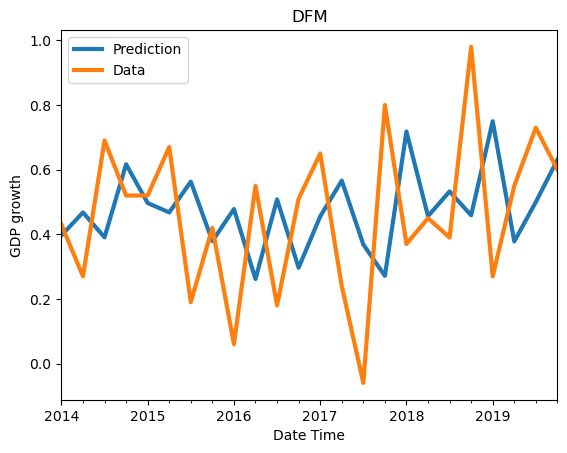

In [146]:
fig, ax = plt.subplots()
dfm2_forecast['GDP'].plot(ax=ax,label='Prediction', lw=3)
test_set['GDP'].plot(ax=ax,label='Data', lw=3)
plt.legend()
plt.title("DFM")
plt.ylabel("GDP growth")
plt.savefig("DFMplot.png")
plt.show()

In [147]:
print('Forecast Accuracy of: GDP')
accuracy_prod = forecast_accuracy(dfm2_forecast['GDP'].values.astype(float), test_set['GDP'].values.astype(float))

compare_results_df["DFM"] = accuracy_prod.values()
 
compare_results_df

Forecast Accuracy of: GDP


,AR(1),ARX,VAR,DFM
mape,1.046693,1.001969,1.042072,1.139337
me,-0.040880,-0.045628,-0.037882,0.017858
mae,0.255580,0.256174,0.251042,0.246835
mpe,0.086261,0.136603,0.086488,0.209295
rmse,0.303869,0.309823,0.305457,0.293471
corr,-0.237768,-0.179728,-0.218724,-0.242312
minmax,0.452661,0.460765,0.443833,0.415644
